In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import string
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 16
#vocabs = ' ' + string.digits + string.ascii_letters + string.punctuation + '°£€¥¢฿'

vocabs = ' ' + "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!#$%&'()+,-.;=@[]^_`{}~°£€¥¢฿"

CHAR2LABEL = {char: i for i, char in enumerate(vocabs)}
LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
class TextDataset(Dataset):
    
    def __init__(self, data_dir, image_names, test_mode=False):
        self.data_dir = data_dir
        self.image_names = image_names
        self.test_mode = test_mode
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        image_path = os.path.join(self.data_dir, image_name)
        image = Image.open(image_path).convert('L')
        if self.test_mode:
          im_k = 32/image.size[1]

          image = image.resize((int(image.size[0]*im_k), 32), resample=Image.BILINEAR) # resize for model
          
        else:
          image = image.resize((600, 32), resample=Image.BILINEAR) # resize for model

        text = image_name.split(".")[0]

        text = [CHAR2LABEL[i] for i in text]

        image = self.transform(image)
        #print(image.size())
        #text = text + [0] * (45 - len(text))
        text = torch.LongTensor(text)
        
        
        
        text_length = [len(text)]
        text_length = torch.LongTensor(text_length)

        return image, text, text_length
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            AddGaussianNoise(0., 1.)
            #transforms.Normalize()
        ])
        return transform_ops(image)

In [ ]:
data_path = '/content/drive/MyDrive/img_fonts'
image_names = os.listdir(data_path)

image_names_train, image_names_test = train_test_split(image_names, random_state=0)
print(len(image_names_train), len(image_names_test))

trainset = TextDataset(data_path, image_names_train)
testset = TextDataset(data_path, image_names_test)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

2250 750


In [ ]:
len(image_names)

3000

In [ ]:
for i in image_names:
  if i[-4:] != '.png': print(i)

In [ ]:
iter(train_loader).next()
None

In [ ]:
class CRNN(nn.Module):
    
    def __init__(self, voc_len):
        super(CRNN, self).__init__()

        self.voc_len = voc_len

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(64, 128,kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2), stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d((1, 2), stride=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d((1, 2), stride=2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0)
        
        self.norm = nn.BatchNorm2d(512)

        self.rnn1 = nn.LSTM(input_size=512,hidden_size=256, bidirectional=True)
        self.rnn2 = nn.LSTM(input_size=512,hidden_size=256, bidirectional=True)
      
        self.linear1 = nn.Linear(512, 512) 
        self.linear2 = nn.Linear(512, self.voc_len)
        
        
        
    def forward(self, images):

        images = F.relu(self.conv1(images))
        images = self.pool1(images)
        images = F.relu(self.conv2(images))
        images = self.pool2(images)
        images = F.relu(self.conv3(images))
        images = F.relu(self.conv4(images))
        images = self.pool3(images)
        images = F.relu(self.conv5(images))
        
        images = self.norm(images)
        images = F.relu(self.conv6(images))
        images = self.norm(images)

        images = self.pool4(images)
    
        images = F.relu(self.conv7(images))
        
      
        batch, channel, height, width = images.size()

        images = images.view(batch, channel * height, width)
        images = images.permute(2, 0, 1)  # (width, batch, feature)
        
        images = self.linear1(images)

        #rnn
        rnn, _ = self.rnn1(images)
        rnn, _ = self.rnn2(rnn)

        out = self.linear2(rnn)
        
        return out

In [ ]:
model = CRNN(len(vocabs))
model.to(device)

CRNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
  (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn

In [ ]:
criterion = nn.CTCLoss(blank=0)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
def train_batch(crnn, data, optimizer, criterion, device):
    crnn.train()
    images, targets, target_lengths = [d.to(device) for d in data]
    #targets = torch.Tensor(list(targets))


    logits = crnn(images)
    log_probs = torch.nn.functional.log_softmax(logits, dim=2)

    batch_size = images.size(0)
    input_lengths = torch.LongTensor([logits.size(0)] * batch_size)

    target_lengths = torch.flatten(target_lengths)

    loss = criterion(log_probs, targets, input_lengths, target_lengths)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(crnn.parameters(), 5) # gradient clipping with 5
    optimizer.step()
    return loss.item()

In [ ]:
epochs = 100

epoch_losses = []
num_updates_epochs = []
flag = True

for epoch in range(1, epochs + 1):
      print(f'epoch: {epoch}', end='\t')
      tot_train_loss = 0.
      tot_train_count = 0
      if flag == False: break
      for train_data in train_loader:
          
          loss = train_batch(model, train_data, optimizer, criterion, device)

          epoch_losses.append(loss)
          num_updates_epochs.append(epoch)

          train_size = train_data[0].size(0)

          tot_train_loss += loss
          tot_train_count += train_size

          if tot_train_loss / tot_train_count < 5e-5: 
            flag = False
            break
          
      #lr_scheduler.step(tot_train_loss / tot_train_count)
      #scheduler.step()
      print('train_loss: ', tot_train_loss / tot_train_count)

epoch: 1	train_loss:  0.27185511355929903
epoch: 2	train_loss:  0.25713256719377303
epoch: 3	train_loss:  0.21715992228190104
epoch: 4	train_loss:  0.13945723337597318
epoch: 5	train_loss:  0.07743424595726861
epoch: 6	train_loss:  0.04550635965665181
epoch: 7	train_loss:  0.03305879225995806
epoch: 8	train_loss:  0.02742528057098389
epoch: 9	train_loss:  0.023452304071850248
epoch: 10	train_loss:  0.02073190481795205
epoch: 11	train_loss:  0.019063009705808428
epoch: 12	train_loss:  0.01734439320696725
epoch: 13	train_loss:  0.016102043853865728
epoch: 14	train_loss:  0.01579751353462537
epoch: 15	train_loss:  0.015343313134378858
epoch: 16	train_loss:  0.01402406597799725
epoch: 17	train_loss:  0.013504119038581848
epoch: 18	train_loss:  0.013101348363690906
epoch: 19	train_loss:  0.012154609557655122
epoch: 20	train_loss:  0.011969370600250032
epoch: 21	train_loss:  0.011547881990671157
epoch: 22	train_loss:  0.011418301032649146
epoch: 23	train_loss:  0.010813921944962607
epoch: 24

Text(0, 0.5, 'Loss')

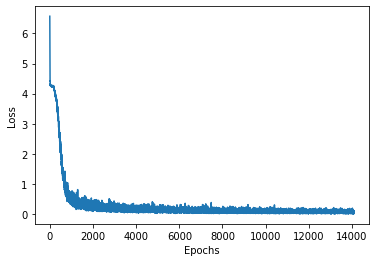

In [ ]:
fig, ax = plt.subplots()

ax.plot(epoch_losses)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")


In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [LABEL2CHAR[int(idx)] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
def real_text(text_tokens):
    text_tokens = text_tokens.numpy()
    tr = []
    for text_token in text_tokens:
        text = [LABEL2CHAR[int(idx)] for idx in text_token]
        text = "".join(text)
        tr.append(text)
    return tr

In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split(" ")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
test = []
pred = []
with torch.no_grad():
    for image_batch, text_batch, _ in tqdm(test_loader, leave=True):
        text_batch_logits = model(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        
        text_batch_pred = decode_predictions(text_batch_logits.cpu())

        #print(real_text(text_batch), text_batch_pred)
        test += real_text(text_batch) 
        pred += text_batch_pred

  0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
pred = [correct_prediction(t) for t in pred]

In [ ]:
accuracy_score(test, pred)

0.39066666666666666

In [ ]:
new_text = '/content/drive/MyDrive/forward'
new_ds = TextDataset(new_text,['0orERvaY9C.png'], test_mode=True)
new_dl = DataLoader(new_ds, batch_size=1)

In [ ]:
im, tx, ln = [d.to(device) for d in iter(new_dl).next()]

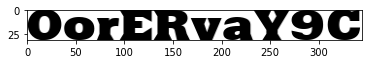

In [ ]:
plt.imshow(Image.open('/content/drive/MyDrive/forward/0orERvaY9C.png'))
plt.show()

In [ ]:
im[0][0].shape

torch.Size([32, 356])

AttributeError: ignored

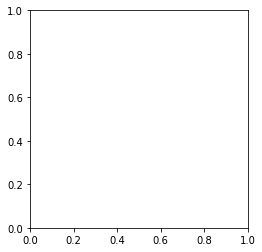

In [ ]:
plt.imshow(im[0][0].cpu().numpy(), col')
plt.show()

In [ ]:
with torch.no_grad():
  res = model(im)
  text_pred = decode_predictions(res.cpu())
  tx_pr = correct_prediction(text_pred[0])

In [ ]:
tx_pr

'OorERvaY9L'

In [ ]:
real_text(tx.cpu())[0]

'0orERvaY9C'

orig: 6OrgRIod6Eh013eGUk7u,	pred: 6OrgRIcd6EhO13eGUk7u


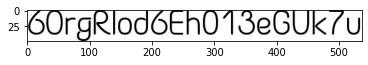

orig: ZqfPNmRzfPWIOXY22rIc,	pred: ZqfFNmRzfPWIOXY22nc


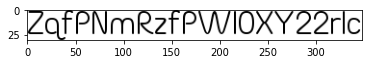

orig: HKMwzA0dOmSYYyAKFM7b,	pred: HKMwzA0d0mSYYyAKHM7b


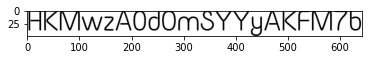

orig: lvWEGkjpaivhXlwmnr5T,	pred: lvWEGkjpaivhXlwmnr5T


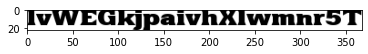

orig: BOagMGQBV48O6rKKBkp2,	pred: BCagMG0BV48O6rKKBkX2


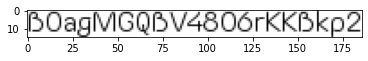

In [ ]:
for i, v in enumerate(test[:5]):
    print(f'orig: {v},\tpred: {pred[i]}')
    img = Image.open(os.path.join(data_path, v +'.png'))
    plt.imshow(img)
    plt.show()

orig: FDb0GmnItt7PTNyOMYIx,	pred: FDb0GmnIt7PTNyOMYIx


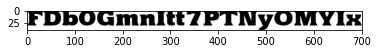

orig: 7rr0AZNVLi32V3oo1Txi,	pred: 7rr0AZNVLi32V3o1Txi


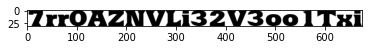

orig: ANaRqr7vvb2MN2BRgqat,	pred: ANaRqr7vvb2MN2BRgqar


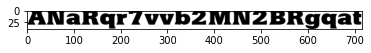

orig: cCoPTkfHb0lRDV5HwJJd,	pred: cCoPTkfHb0lRDV5HwJd


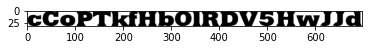

orig: Rf3ElMD2u6dyHD1bYovv,	pred: Rf3ElMD2u6dyHD1bYov


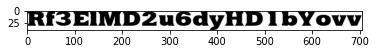

orig: eZSmXN1wFPbVKKbgxNGx,	pred: eZSmXN1wFPbVKbgxNGx


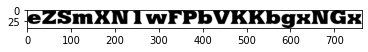

orig: hbXz3CqSsGaFyURENFFE,	pred: hbXz3CqSsGaFyURENFE


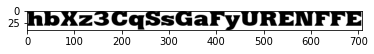

orig: w3Puf5CJGu9B6BSjJ5ss,	pred: w3Puf5CJGu9B6BSjJ5s


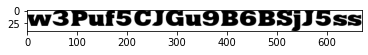

orig: AvWjjtstedUtZlhVJnJu,	pred: AvVWjjtstedUtZlhVJnJu


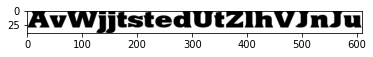

orig: 8CFRwGBvtLWP49Z0VYfi,	pred: 8CFRwGBvtLWP49Z0VYj


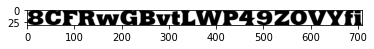

orig: pzHkVPdiDPVFTQigHvqq,	pred: pzHkVPdiDPVFTQigHvq


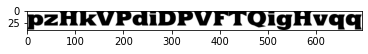

orig: MV3uxevTS392eU20guYY,	pred: MV3uxevTS392eU20guY


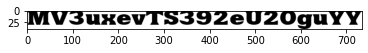

orig: jWmch0VHMOyxjId0LK5H,	pred: jWmch0VHMOyxjd0LK5H


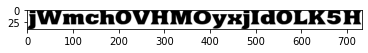

orig: 6gs84dlLUs0JBpqRvUfI,	pred: 6gs84dlLUs0JBpqRvUI


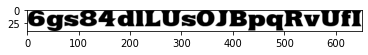

orig: bi66q6RX6MrvJq7gdHM9,	pred: bi6q6RX6MrvJq7gdHM9


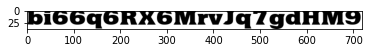

orig: t803h9C0umRessQEfN9Z,	pred: t803h9C0umResQEfN9Z


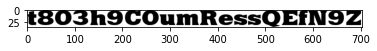

orig: kJ44Va4qGvv47WT4PIgn,	pred: kJ44Va4qGv47WT4PIgn


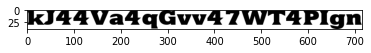

orig: o9fFJJWhV1JgVfUVPJxl,	pred: o9fFJWhV1JgVfUVPJxl


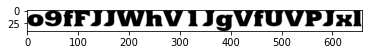

orig: k8skMd1Hff7uBv45ERCt,	pred: k8skMd1Hf7uBv45ERCt


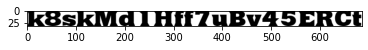

orig: VmoQCXIoxBi2g6cFa7cc,	pred: VmoQCXIoxBi2g6cFa7c


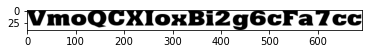

orig: 6QmnhA6yURbWXmSIWpvl,	pred: 6QmnhA6yURbWXmSIWpl


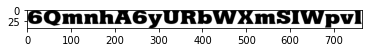

orig: NXhy7NjDF4MjjDQRDyMh,	pred: NXhy7NjDF4MjDQRDyMh


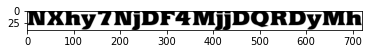

orig: i7nCdXEtHyYlicgc7I0D,	pred: i7nCdXEtHyYlircgc7I0D


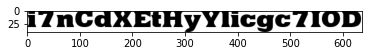

orig: GSTFHEAO2J0f93ooqEIt,	pred: GSTFHEAO2J0f93ooqEt


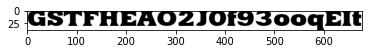

orig: JaL7PNkcki3yFSRSlLjl,	pred: JaL7PNkcki3yFSRSlLl


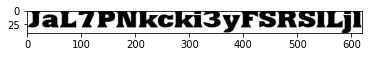

orig: xPXhMX0eTRYnW3EZ8BBG,	pred: xPXhMX0eTRYnW3EZ8BG


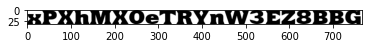

orig: KbZpkRWNWkzLlBKyFcbj,	pred: KbZpkRWNWkzLlBKyFcj


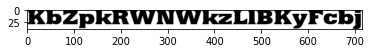

orig: 9O2KfHNtN7EPCooiYm4e,	pred: 9O2KfHNtN7EPCoiYm4e


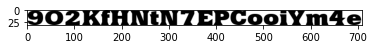

orig: 7dw4VG5LLRpYb0ahXdWe,	pred: 7dw4VG5LRpYb0ahXdWe


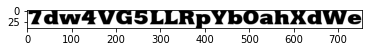

orig: NMMfYyHftl27YJJV1xk9,	pred: NMMfYyHftl27YJV1xk9


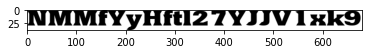

orig: dDPV2gf0ROMrIlmubPEb,	pred: dDPV2gf0ROMrlmubPEb


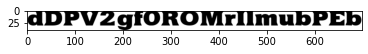

orig: MnsXtLxxqkAdPsU8vM6E,	pred: MnsXtLxqkAdPsU8vM6E


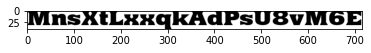

orig: 333G70GgXB4RRWIKk9Tz,	pred: 33G70GgXB4RRWIKk9Tz


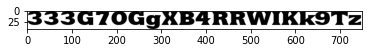

orig: 7wX6rKkH11c2bk1eICss,	pred: 7wX6rKkH11c2bk1eICs


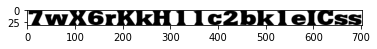

orig: evv2yGLkQz68HtHuwIBD,	pred: ev2yGLkQz68HtHuwIBD


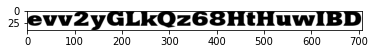

orig: Pr6FFHToU8b9KrrD6AzY,	pred: Pr6FHToU8b9KrrD6AzY


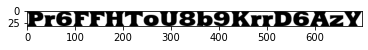

orig: UxQpzVMzVt4lJDqqA7Dh,	pred: UxQpzVMzVt4lJDqA7Dh


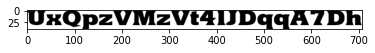

orig: ZZpJAA5MrrzqORMET8Rd,	pred: ZpJAA5MrzqORMET8Rd


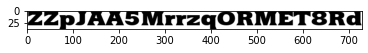

orig: skdi67hECdL27rOvoqrr,	pred: skdi67hECdL27rOvoqr


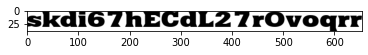

orig: yFOAIxbuE5yffkU8Y7yy,	pred: yFOAIxbuE5yffkU8Y7y


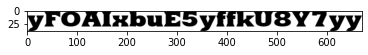

In [ ]:
for i, v in enumerate(test):
    if v != pred[i]:
      print(f'orig: {v},\tpred: {pred[i]}')
      img = Image.open(os.path.join(data_path, v +'.png'))
      plt.imshow(img)
      plt.show()